In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# module, library import

# dataloader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from kogpt2_transformers import get_kogpt2_tokenizer

# model configuration
import logging
from transformers.configuration_utils import PretrainedConfig
from transformers import GPT2Config

# model
# import torch.nn as nn
from kogpt2_transformers import get_kogpt2_model

# train
import sys
sys.path.append('/content/drive/MyDrive/my_ws/project/aischool-final')
sys.path.append('/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM')

import os
import numpy as np
from tqdm import tqdm

# import torch
from torch.utils.data import dataloader

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# dataloader
class WellnessAutoRegressiveDataset(Dataset):
  """Wellness Auto Regressive Dataset"""
  def __init__(self,
               file_path,
               n_ctx = 1024
               ):
    self.file_path = file_path
    self.data =[]
    self.tokenizer = get_kogpt2_tokenizer()

    bos_token_id = [self.tokenizer.bos_token_id]
    eos_token_id = [self.tokenizer.eos_token_id]
    pad_token_id = [self.tokenizer.pad_token_id]

    file = open(self.file_path, 'r', encoding='utf-8')

    while True:
      line = file.readline()
      if not line:
        break
      datas = line.split("    ")
      index_of_words = bos_token_id +self.tokenizer.encode(datas[0]) + eos_token_id + bos_token_id + self.tokenizer.encode(datas[1][:-1])+ eos_token_id
      pad_token_len = n_ctx - len(index_of_words)

      index_of_words += pad_token_id * pad_token_len

      self.data.append(index_of_words)

    file.close()

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    item = self.data[index]
    return item


# model configuration
logger = logging.getLogger(__name__)

#KoGPT2
kogpt2_config = {
    "initializer_range": 0.02,
    "layer_norm_epsilon": 1e-08,
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_layer": 12,
    "n_positions": 1024,
    "vocab_size": 50000,
    "activation_function": "gelu"
}

def get_kogpt2_config():
    return GPT2Config.from_dict(kogpt2_config)


# model
class DialogKoGPT2(nn.Module):
  def __init__(self):
    super(DialogKoGPT2, self).__init__()
    self.kogpt2 = get_kogpt2_model()

  def generate(self,
               input_ids,
               do_sample=True,
               max_length= 60,
               top_p=1,
               top_k=50,
               temperature= 0.6,
               no_repeat_ngram_size=2,
               num_return_sequences=1,
               early_stopping=True,
               ):
    return self.kogpt2.generate(input_ids,
               do_sample=do_sample,
               max_length=max_length,
               top_p = top_p,
               top_k=top_k,
               temperature=temperature,
               no_repeat_ngram_size= no_repeat_ngram_size,
               num_return_sequences=num_return_sequences,
               early_stopping = early_stopping,
              )

  def forward(self, input, labels = None):
    if labels is not None:
      outputs = self.kogpt2(input, labels=labels)
    else:
      outputs = self.kogpt2(input)

    return outputs

### Training(first) : T4 GPU

In [ ]:
## at the first time of Training
root_path = '/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM'
train_data_path = f"{root_path}/data/wellness_dialog_for_autoregressive_train.txt"
val_data_path = f"{root_path}/data/wellness_dialog_for_autoregressive_validation.txt"
save_ckpt_path = f"{root_path}/checkpoint/kogpt2-wellnesee-auto-regressive_hyper.pth"

batch_size = 2
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)

n_epoch = 10
save_step = 100
learning_rate = 3e-4

# Training data loader
train_dataset = WellnessAutoRegressiveDataset(train_data_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data loader
val_dataset = WellnessAutoRegressiveDataset(val_data_path)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model initialization
model = DialogKoGPT2()
model.to(device)

# Loss function and optimizer
loss_fct = torch.nn.CrossEntropyLoss(ignore_index=3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
losses = []
val_losses = []

for epoch in range(n_epoch):
    count = 0
    with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            data = torch.stack(data)
            data = data.transpose(1, 0)
            data = data.to(ctx)

            outputs = model(data, labels=data)
            _, logits = outputs[:2]

            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = data[..., 1:].contiguous()

            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if (count > 0 and count % save_step == 0) or (len(data) < batch_size):
                torch.save({
                    'epoch': epoch,
                    'train_no': count,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                }, save_ckpt_path)

            count += 1
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

    # Validation loop
    with torch.no_grad():
        with tqdm(total=len(val_loader), desc=f"Validation") as val_pbar:
            for j, val_data in enumerate(val_loader):
                val_data = torch.stack(val_data)
                val_data = val_data.transpose(1, 0)
                val_data = val_data.to(ctx)

                val_outputs = model(val_data, labels=val_data)
                _, val_logits = val_outputs[:2]

                val_shift_logits = val_logits[..., :-1, :].contiguous()
                val_shift_labels = val_data[..., 1:].contiguous()

                val_loss = loss_fct(val_shift_logits.view(-1, val_shift_logits.size(-1)), val_shift_labels.view(-1))
                val_losses.append(val_loss.item())

                val_pbar.update(1)
                val_pbar.set_postfix_str(f"Validation Loss: {val_loss.item():.3f} ({np.mean(val_losses):.3f})")

    # Print validation loss at the end of each epoch
    print(f"Validation Loss (Epoch {epoch + 1}): {np.mean(val_losses):.3f}")

# End of training

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

Validation: 100%|██████████| 793/793 [03:22<00:00,  3.91it/s, Validation Loss: 2.112 (1.128)]


Validation Loss (Epoch 1): 1.128


Validation: 100%|██████████| 793/793 [03:23<00:00,  3.90it/s, Validation Loss: 1.941 (0.964)]


Validation Loss (Epoch 2): 0.964


Validation: 100%|██████████| 793/793 [03:22<00:00,  3.92it/s, Validation Loss: 2.127 (0.884)]


Validation Loss (Epoch 3): 0.884


Train(3):  98%|█████████▊| 6212/6343 [1:29:23<01:34,  1.38it/s, Loss: 0.623 (0.902)]

### Training(Subsequently) : V100 GPU

In [ ]:
## Subsequently

root_path = '/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM'
train_data_path = f"{root_path}/data/wellness_dialog_for_autoregressive_train.txt"
val_data_path = f"{root_path}/data/wellness_dialog_for_autoregressive_validation.txt"
save_ckpt_path = f"{root_path}/checkpoint/kogpt2-wellnesee-auto-regressive_hyper.pth"

batch_size = 2
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)

n_epoch = 10
save_step = 100
learning_rate = 3e-4

# Training data loader
train_dataset = WellnessAutoRegressiveDataset(train_data_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data loader
val_dataset = WellnessAutoRegressiveDataset(val_data_path)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model initialization
model = DialogKoGPT2()
model.to(device)

# Loss function and optimizer
loss_fct = torch.nn.CrossEntropyLoss(ignore_index=3)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Get the model you trained before
if os.path.isfile(save_ckpt_path):
  checkpoint = torch.load(save_ckpt_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  start_train_no = checkpoint['train_no'] + 1  # starting from the next loop

  n_epoch_additional = 6  # Modify to the remaining number of times

  # Training loop
  losses = []
  val_losses = []

  for epoch in range(start_epoch, start_epoch + n_epoch_additional):
      count = start_train_no
      with tqdm(total=len(train_loader), desc=f"Train({epoch})") as pbar:
          for i, data in enumerate(train_loader):
              optimizer.zero_grad()
              data = torch.stack(data)
              data = data.transpose(1, 0)
              data = data.to(ctx)

              outputs = model(data, labels=data)
              _, logits = outputs[:2]

              shift_logits = logits[..., :-1, :].contiguous()
              shift_labels = data[..., 1:].contiguous()

              loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
              loss.backward()
              optimizer.step()

              losses.append(loss.item())

              if (count > 0 and count % save_step == 0) or (len(data) < batch_size):
                  torch.save({
                      'epoch': epoch,
                      'train_no': count,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': loss
                  }, save_ckpt_path)

              count += 1
              pbar.update(1)
              pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

      # Validation loop
      with torch.no_grad():
          with tqdm(total=len(val_loader), desc=f"Validation") as val_pbar:
              for j, val_data in enumerate(val_loader):
                  val_data = torch.stack(val_data)
                  val_data = val_data.transpose(1, 0)
                  val_data = val_data.to(ctx)

                  val_outputs = model(val_data, labels=val_data)
                  _, val_logits = val_outputs[:2]

                  val_shift_logits = val_logits[..., :-1, :].contiguous()
                  val_shift_labels = val_data[..., 1:].contiguous()

                  val_loss = loss_fct(val_shift_logits.view(-1, val_shift_logits.size(-1)), val_shift_labels.view(-1))
                  val_losses.append(val_loss.item())

                  val_pbar.update(1)
                  val_pbar.set_postfix_str(f"Validation Loss: {val_loss.item():.3f} ({np.mean(val_losses):.3f})")

      # Print validation loss at the end of each epoch
      print(f"Validation Loss (Epoch {epoch + 1}): {np.mean(val_losses):.3f}")

  # End of training

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
Validation: 100%|██████████| 793/793 [01:02<00:00, 12.77it/s, Validation Loss: 2.192 (0.695)]


Validation Loss (Epoch 4): 0.695


Validation: 100%|██████████| 793/793 [01:02<00:00, 12.72it/s, Validation Loss: 2.225 (0.689)]


Validation Loss (Epoch 5): 0.689


Validation: 100%|██████████| 793/793 [01:01<00:00, 12.79it/s, Validation Loss: 2.138 (0.687)]


Validation Loss (Epoch 6): 0.687


Validation: 100%|██████████| 793/793 [01:02<00:00, 12.76it/s, Validation Loss: 2.208 (0.683)]


Validation Loss (Epoch 7): 0.683


Validation: 100%|██████████| 793/793 [01:01<00:00, 12.83it/s, Validation Loss: 2.192 (0.680)]


Validation Loss (Epoch 8): 0.680


Validation: 100%|██████████| 793/793 [01:02<00:00, 12.75it/s, Validation Loss: 2.024 (0.677)]

Validation Loss (Epoch 9): 0.677


In [ ]:
import pandas as pd
import numpy as np
loss_train = pd.DataFrame()
loss_train['train_loss']=losses
loss_train.to_excel('/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM/train_loss.xlsx',index=False)

loss_valid = pd.DataFrame()
loss_valid['valid_loss']=val_losses
loss_valid.to_excel('/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM/valid_loss.xlsx',index=False)

In [ ]:
epoch_list = range(1,10)
train_loss = [1.740,1.247, 1.025,0.580,0.488,0.481,0.475,0.470,0.465]
valid_loss = [1.128, 0.964, 0.884, 0.695, 0.689,0.687,0.683,0.680,0.677]

df = pd.DataFrame(index=epoch_list)
df['train_loss']=train_loss
df['valid_loss']=valid_loss
df.to_excel('/content/drive/MyDrive/my_ws/project/aischool-final/dialogLM/epoch_loss.xlsx',index=False)

Text(0.5, 0, 'epoch')

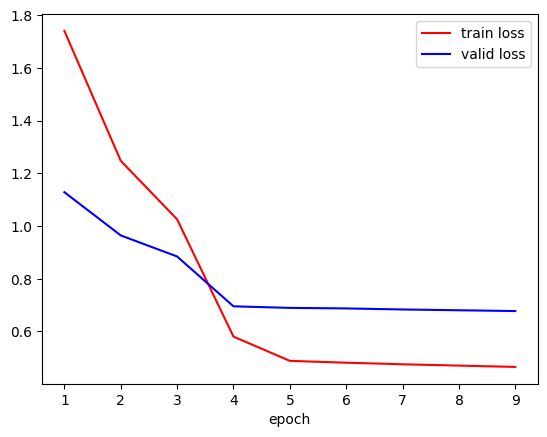

In [ ]:
plt.plot(epoch_list,train_loss,color='r',label='train loss')
plt.plot(epoch_list,valid_loss,color='b',label='valid loss')
plt.legend()
plt.xlabel('epoch')

In [ ]:
!nvidia-smi

Wed Jan 24 01:20:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--